In [88]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from mintpy.utils import readfile, utils as ut

import platemotion
from scipy import interpolate
from astropy import units as u

import time

In [39]:
def build_PMM(platename, wxyz=None, pole=None, plateBound='MRVL', plot=False):
    
    pkg_dir = os.path.dirname(platemotion.__file__)
    
    if plateBound == 'MRVL':
        csvfile = f'{pkg_dir}/data/NNR_MRV56.csv'
        bndsdir = 'NnrMRVL_PltBndsLatLon'
    elif plateBound == 'GSRM':
        csvfile = f'{pkg_dir}/data/NNR_GSRMv2.1.csv'
        bndsdir = 'NnrGSRMv2.1_PltBndsLatLon'
        
    df = pd.read_csv(csvfile, header=0, squeeze=True)
    plate_ab = df.set_index('Plate').T.to_dict('records')[0]
    

    plate = platemotion.Plate.from_file(f'{pkg_dir}/data/{bndsdir}/{plate_ab[platename]}',skiprows=1)
    plate.set_name(platename)

    # Check input variables
    if (wxyz is None) and (pole is None):
        print('Need to give either omega_cartesian (wxyz) or omega_spherical (euler pole)!!')
        sys.exit(1)

    elif wxyz is not None:
        print('Input: omega_cartesian (wxyz)')        
        omega = np.array(wxyz) * u.mas/u.yr      
        plate.set_omega(omega,'cartesian')     
        
    else:
        print('Input: omega_spherical (euler pole)')
        omega = [pole[0]*u.deg, pole[1]*u.deg, pole[2]*u.deg/u.Ma]
        plate.set_omega(omega,'spherical')
        

    print('\nPlate: {}'.format(platename))
    print('\nCartesian rotation vector:')
    print(' wx:            {:.4f}'.format(plate.omega_cartesian[0]))
    print(' wy:            {:.4f}'.format(plate.omega_cartesian[1]))
    print(' wz:            {:.4f}'.format(plate.omega_cartesian[2]))
    print('\nEuler pole representation:')
    print(' Latitude:      {:.4f} deg'.format(plate.omega_spherical[0].degree))
    print(' Longitude:     {:.4f} deg'.format(plate.omega_spherical[1].degree))
    print(' Rotation rate: {:.4f} '.format(plate.omega_spherical[2].to(u.deg/u.Ma)))
    
    if plot:
        plate.plot()
    return plate


def mesh_2dll(lat12, lon12, l=50, w=50):
    lats = np.linspace(lat12[0], lat12[1], int(l))
    lons = np.linspace(lon12[0], lon12[1], int(w))
    Lons, Lats = np.meshgrid(lons, lats)
    return Lats, Lons


def pmm_lalo_enu(pmm, Lats, Lons):
    """
    Input:
        pmm     plate motion model instance
        Lats    2D array of latitudes;                 dim = (length, width)
        Lons    2D array of longitudes;                dim = (length, width)
        
    Output:
        enu     3D array of {east, north, up} motions; dim = (length, width, 3)
    """
    try:
        n    = len(Lats)
        Lats = np.array(Lats)
        Lons = np.array(Lons)
    except:
        pass
        
    if isinstance(Lats, float) or isinstance(Lats, int):
        print('Single location')        
        loc = np.array([Lats, Lons, 0])
        v   = pmm.velocity_at(loc,'geodetic')
        en  = np.array(v.en)
        enu = np.concatenate((en, [0]))

    elif len(Lats.shape) == 1:
        print('1D array locations')        
        ele  = np.zeros_like(Lats)
        locs = np.dstack((Lats, Lons, ele))[0].T
        v    = pmm.velocity_at(locs,'geodetic')
        en   = np.array(v.en).reshape([-1,2])
        enu  = np.concatenate((en, np.zeros([en.shape[0],1])),1)
        
    elif len(Lats.shape) > 1:
        print('2D array locations')        
        length, width = Lats.shape
        ele  = np.zeros_like(Lats)
        locs = np.dstack((Lats, Lons, ele))
        locs = locs.reshape([-1, 3]).T
        v    = pmm.velocity_at(locs,'geodetic')
        en   = np.array(v.en).reshape([-1,2])
        enu  = np.concatenate((en, np.zeros([en.shape[0],1])),1)
        enu  = enu.reshape([length, width, -1])

    else:
        print('Weird input')
    
    return enu

Input: omega_cartesian (wxyz)

Plate: Arabia

Cartesian rotation vector:
 wx:            1.1540 mas / yr
 wy:            -0.1360 mas / yr
 wz:            1.4440 mas / yr

Euler pole representation:
 Latitude:      51.1764 deg
 Longitude:     353.2786 deg
 Rotation rate: 0.5149 deg / Ma 


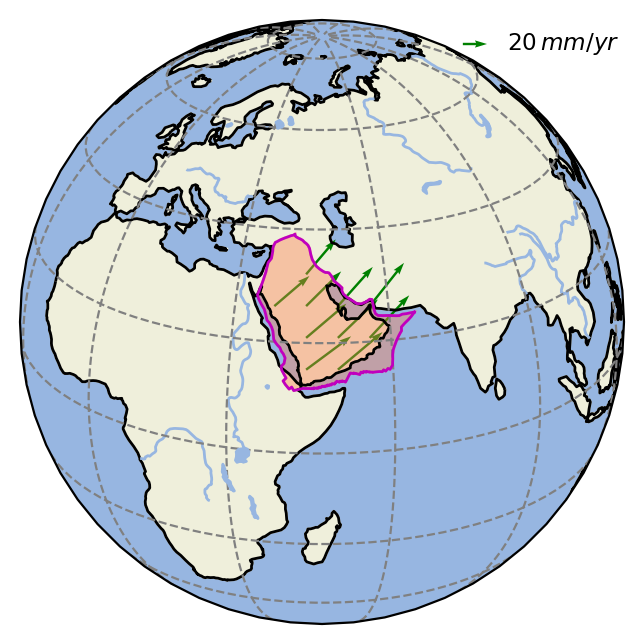

In [3]:
## ITRF_2014-PMM
# plate_list = ['Arabia', 'Australia', 'Antarctica', 'Nubia', 'Eurasia']
# Euler pole model from: Altamimi et. al., 2017 GJI
# plate_wxyz = [[1.154, -0.136, 1.444 ], [1.510, 1.182, 1.215], [-0.248, -0.324, 0.675], [0.099, -0.614, 0.733], [-0.085, -0.531, 0.770]]


omega = [1.154, -0.136, 1.444 ]
plate = build_PMM('Arabia', wxyz=omega, plateBound='MRVL', plot=True)

In [44]:
# Demonstrate a single location (lat, lon)
enu = pmm_lalo_enu(plate, 30, 30)
print(enu)


# Demonstrate an 1D array multiple locations
enu = pmm_lalo_enu(plate, [30,31], [30,36])
print(enu)

Single location
[24.38582603 21.46613161  0.        ]
1D array locations
[[24.38582603 21.46613161  0.        ]
 [24.79128846 24.35527236  0.        ]]


(775,)

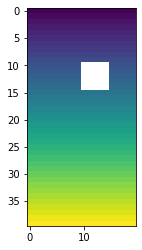

In [109]:
lat12 = [30,32]
lon12 = [34, 36]
Lats, Lons = mesh_2dll([lat12[0], lat12[1]], [lon12[0], lon12[1]], l=40, w=20)

Lats[10:15, 10:15] = np.nan
plt.imshow(Lats)

mask = np.ma.masked_invalid(Lats)
Lats[~mask.mask].shape

In [141]:
# Demonstrate an 2D array multiple locations, and convert to LOS vectors

def interp_2d3l_grid(data, X, Y, nx, ny, kind):
    ## Interpolate 3-layer 2D arrays individually
    y_new    = np.linspace(np.min(Y), np.max(Y), ny)
    x_new    = np.linspace(np.min(X), np.max(X), nx)
    data_new = np.empty([len(y_new), len(x_new), 3])
    X_new, Y_new = np.meshgrid(x_new, y_new)    
    
    mask = np.ma.masked_invalid(data[:,:,0])
    
    print('Mask {}. unmask {}'.format(np.sum(mask.mask), np.sum(~mask.mask)))
    
    x1     = X[~mask.mask]
    y1     = Y[~mask.mask]
    data_0 = data[:,:,0][~mask.mask]
    data_1 = data[:,:,1][~mask.mask]
    data_2 = data[:,:,2][~mask.mask]
    
    data_new[:,:,0] = interpolate.griddata((x1, y1), data_0.ravel(), (X_new, Y_new), method=kind)
    data_new[:,:,1] = interpolate.griddata((x1, y1), data_1.ravel(), (X_new, Y_new), method=kind)
    data_new[:,:,2] = interpolate.griddata((x1, y1), data_2.ravel(), (X_new, Y_new), method=kind)

    return data_new


def interp_2d3l(data, X, Y, nx, ny, kind):
    ## Interpolate 3-layer 2D arrays individually
    f0 = interpolate.interp2d(X, Y, data[:,:,0], kind=kind)
    f1 = interpolate.interp2d(X, Y, data[:,:,1], kind=kind)
    f2 = interpolate.interp2d(X, Y, data[:,:,2], kind=kind)

    y_new = np.linspace(np.min(Y), np.max(Y), ny)
    x_new = np.linspace(np.min(X), np.max(X), nx)

    data_new = np.empty([len(y_new), len(x_new), 3])
    data_new[:,:,0] = f0(x_new, y_new)
    data_new[:,:,1] = f1(x_new, y_new)
    data_new[:,:,2] = f2(x_new, y_new)

    return data_new


def test_2d(lat12, lon12, l, w, dl, dw, interp=False):

    tic = time.perf_counter()

    Lats, Lons = mesh_2dll([lat12[0], lat12[1]], [lon12[0], lon12[1]], l=l/dl, w=w/dw)
    enu  = pmm_lalo_enu(plate, Lats, Lons)
    enu[30:, 0:5, :] = np.nan
    plt.figure()
    plt.imshow(enu[:,:,0])
    plt.show()

    if interp:
        #enu_new = interp_2d3l(enu, Lons, Lats, w, l, interp)
        enu_new = interp_2d3l_grid(enu, Lons, Lats, w, l, interp)        
        enu = np.array(enu_new)

    vlos = ut.enu2los(enu[:,:,0], enu[:,:,1], enu[:,:,2], inc_angle=44.15, az_angle=-260.3)

    toc = time.perf_counter()
    print(f"PMM to ENU to V_LOS in {toc-tic:0.4f} seconds for {Lats.size} pixels")
    
    return vlos

2D array locations


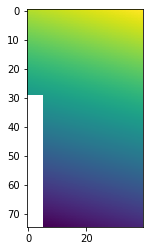

Mask 225. unmask 2775
PMM to ENU to V_LOS in 8.2720 seconds for 3000 pixels


In [144]:
#vlos = test_2d([30,34], [34,36], 1500, 800, 10, 10, interp='linear')
vlos = test_2d([30,34], [34,36], 1500, 800, 20, 20, interp='cubic')
#vlos = test_2d([30,34], [34,36], 1500, 800, 40, 40, interp='linear')


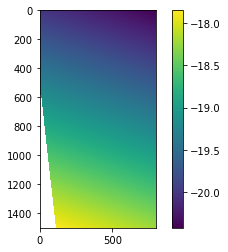

In [145]:
plt.figure
#im = plt.imshow(enu[:,:,0])
im = plt.imshow(vlos)
plt.colorbar(im)
plt.show()

In [42]:
1/40 PMM to ENU to V_LOS in 1.6597 seconds for 740 pixels
1/20 PMM to ENU to V_LOS in 6.7001 seconds for 3000 pixels
1/10 PMM to ENU to V_LOS in 26.3517 seconds for 12000 pixels
1/5  PMM to ENU to V_LOS in 105.0899 seconds for 48000 pixels

3000

Interpolation in 0.7471 seconds


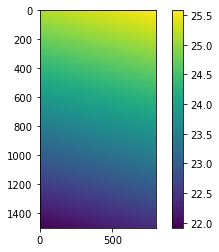

In [74]:
tic = time.perf_counter()

kind = 'linear'

fe = interpolate.interp2d(Lons, Lats, enu[:,:,0], kind=kind)
fn = interpolate.interp2d(Lons, Lats, enu[:,:,1], kind=kind)
fu = interpolate.interp2d(Lons, Lats, enu[:,:,2], kind=kind)

la_new = np.linspace(30, 34, 1500)
lo_new = np.linspace(34, 36,  800)

enu1 = np.empty([len(la_new), len(lo_new), 3])
enu1[:,:,0] = fe(lo_new, la_new)
enu1[:,:,1] = fn(lo_new, la_new)
enu1[:,:,2] = fu(lo_new, la_new)


toc = time.perf_counter()
print(f"Interpolation in {toc-tic:0.4f} seconds")


plt.figure
im = plt.imshow(enu1[:,:,0])
plt.colorbar(im)
plt.show()

In [22]:
enu = pmm_lalo_enu(plate, np.nan, np.nan)
enu

#ut.enu2los(enu[0], enu[1], enu[2], inc_angle=44.15, az_angle=-260.3)


Single location


array([nan, nan,  0.])

In [15]:
len(np.array([[10,10],[10,11]]).shape)

2

In [14]:
len(np.array([10,10]).shape)

1

In [16]:
len(np.array(10).shape)

0

In [149]:
platemodel

NameError: name 'platemodel' is not defined